In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import collections
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
# If not downloaded use following code
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [12]:
# otherwise use this
train_path = '/Users/yuzhang/.keras/datasets/train.tfrecord'
test_path = '/Users/yuzhang/.keras/datasets/test.tfrecord'

In [7]:
def _parse_function(record):
    '''Extract features and labels
    
    record: file path to a TFRecord file
    
    returns a dictionary of features and a tensor with corresponding labels
    '''
    features = {
        'terms': tf.VarLenFeature(dtype = tf.string), # terms are strings of varying lengths
        'labels': tf.FixedLenFeature(shape = [1], dtype = tf.float32) #labels are 0 or 1
    }
    parsed_features = tf.parse_single_example(record, features)
    
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']
    
    return {'terms': terms}, labels

Create input_fn that parses the tf.Examples from the given files and split them into features and targets

In [9]:
def _input_fn(input_filenames, num_epochs = None, shuffle = True):
    '''This function is similar with our previous excises, but is for tf.data.TFRecordDataset
    instead of tf.data.Dataset
    
    return a batch of features and labels
    '''
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.padded_batch(25, ds.output_shapes)
    
    ds = ds.repeat(num_epochs)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Build a Linear Classifier with Sparse Inputs and Explicit Vocabulary
First, construct feature columns with just 50 informative terms

In [10]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key = 'terms',
                                    vocabulary_list = informative_terms)

Construct and train linear classifier

In [31]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
feature_columns = [terms_feature_column]

linear_classifier = tf.estimator.LinearClassifier(feature_columns = feature_columns,
                                                 optimizer = my_optimizer)

linear_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)

In [32]:
# evaluate training effects
eval_metrics = linear_classifier.evaluate(input_fn = lambda: _input_fn([train_path]), steps = 1000)
print('Training set metrics:')
for i in eval_metrics:
    print(i, '-->', eval_metrics[i])
print('---')
eval_metrics = linear_classifier.evaluate(input_fn = lambda: _input_fn([test_path]), steps = 1000)
print('Test set metrics:')
for i in eval_metrics:
    print(i, '-->', eval_metrics[i])
print('---')

Training set metrics:
accuracy --> 0.788
accuracy_baseline --> 0.5
auc --> 0.8709539
auc_precision_recall --> 0.8614863
average_loss --> 0.45294914
label/mean --> 0.5
loss --> 11.323729
prediction/mean --> 0.51966083
global_step --> 1000
---
Test set metrics:
accuracy --> 0.78372
accuracy_baseline --> 0.5
auc --> 0.86876744
auc_precision_recall --> 0.8585781
average_loss --> 0.45433518
label/mean --> 0.5
loss --> 11.35838
prediction/mean --> 0.51749724
global_step --> 1000
---


## Use Deep Neural Network

In [33]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
DNN_classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.indicator_column(terms_feature_column)],
    hidden_units = [20, 20], optimizer = my_optimizer)
try:
    DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([train_path]), steps = 1)
    print('Training set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([test_path]), steps = 1)
    print('Test set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
except ValueError as err:
    print(err)

Training set metrics:
accuracy --> 0.72
accuracy_baseline --> 0.6
auc --> 0.84
auc_precision_recall --> 0.70648265
average_loss --> 0.5334529
label/mean --> 0.4
loss --> 13.336324
prediction/mean --> 0.4017135
global_step --> 1000
---
Test set metrics:
accuracy --> 0.8
accuracy_baseline --> 0.64
auc --> 0.8576388
auc_precision_recall --> 0.73571515
average_loss --> 0.46639276
label/mean --> 0.36
loss --> 11.659819
prediction/mean --> 0.45820323
global_step --> 1000
---


## Build DNN model with Embedding

In [34]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
# Here we use dimension of 2 to visualize.
# In practise, we might project to dimensions higher, like 50 or 100
DNN_classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.embedding_column(terms_feature_column, dimension = 2)],
    hidden_units = [20, 20], optimizer = my_optimizer)
try:
    DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([train_path]), steps = 1)
    print('Training set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([test_path]), steps = 1)
    print('Test set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
except ValueError as err:
    print(err)

Training set metrics:
accuracy --> 0.68
accuracy_baseline --> 0.56
auc --> 0.83766234
auc_precision_recall --> 0.85574543
average_loss --> 0.6048273
label/mean --> 0.56
loss --> 15.120682
prediction/mean --> 0.37285626
global_step --> 1000
---
Test set metrics:
accuracy --> 0.92
accuracy_baseline --> 0.52
auc --> 0.9711538
auc_precision_recall --> 0.96656436
average_loss --> 0.30669105
label/mean --> 0.48
loss --> 7.6672764
prediction/mean --> 0.4916309
global_step --> 1000
---


Notice that in the variables of our models, we have additional terms_embedding/... there, indicating that we do have an embedding

The embedding here is a matrix that project a 50-dimension vector down to 2 dimensions

In [43]:
print(DNN_classifier.get_variable_names())
print('shape of the embedding matrix:', end = ' ')
print(DNN_classifier.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape)
print('And the matrix for the first hidden layer:', end = ' ')
print(DNN_classifier.get_variable_value('dnn/hiddenlayer_0/kernel').shape)

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights', 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
shape of the embedding matrix: (50, 2)
And the matrix for the first hidden layer: (2, 20)


## Examine the Embedding

In [58]:
def visualize_embedding(classifier, informative_terms):
    '''Visualize the projected data
    '''
    embedding_matrix = classifier.get_variable_value(
        'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')
    fig = plt.figure(figsize = (10, 10), dpi = 100)
    for i, item in enumerate(informative_terms):
        terms_vector = np.zeros(len(informative_terms))
        terms_vector[i] = 1
        xy = np.matmul(terms_vector, embedding_matrix)
        plt.plot(xy[0], xy[1], 'o')
        plt.text(xy[0], xy[1], item)
    plt.xlim(1.2*embedding_matrix.min(), 1.2*embedding_matrix.max())
    plt.ylim(1.2*embedding_matrix.min(), 1.2*embedding_matrix.max())

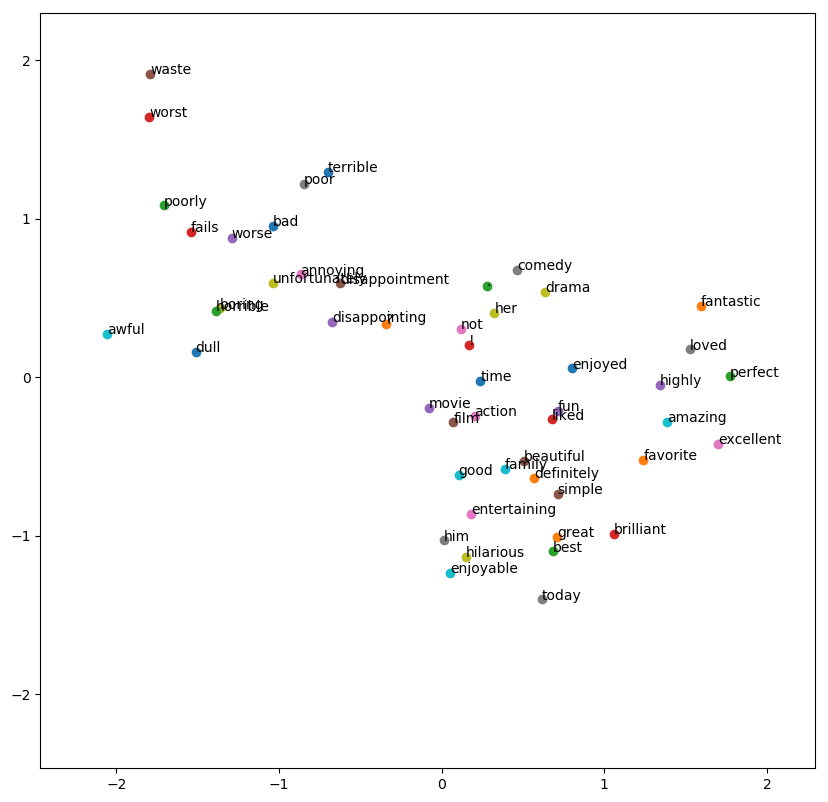

In [59]:
visualize_embedding(DNN_classifier, informative_terms)

We can see from the figure above that the data are clustered: negative words tends to appear at the top left, and positive words appeared at the bottom right.

### Retrain the classifier and see if anything is different

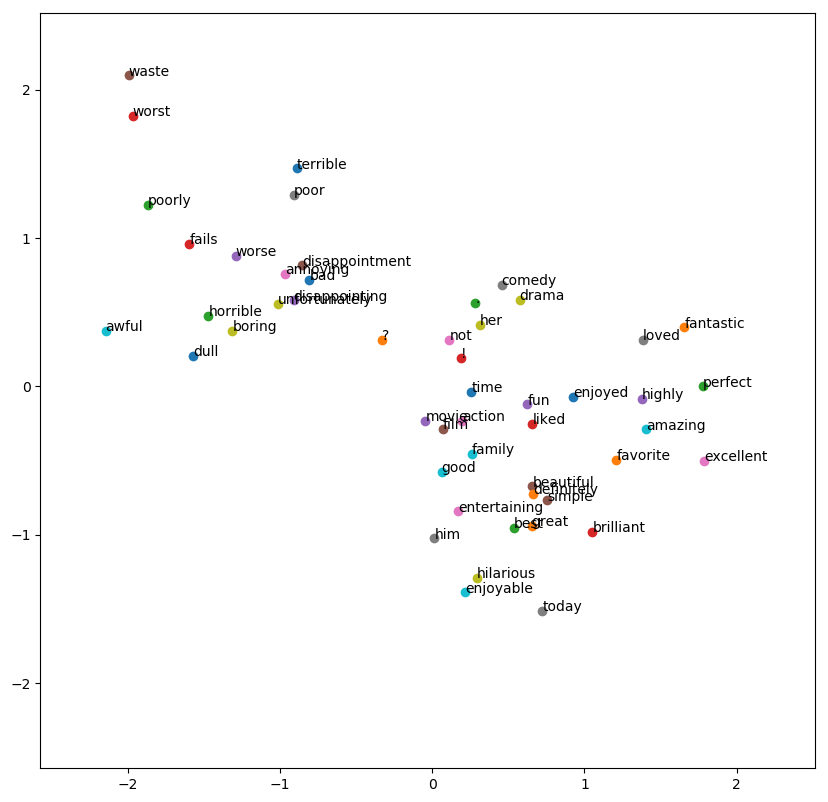

In [60]:
DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)
visualize_embedding(DNN_classifier, informative_terms)

**The projected data stays the same!**

### Retrain the model using only 10 steps

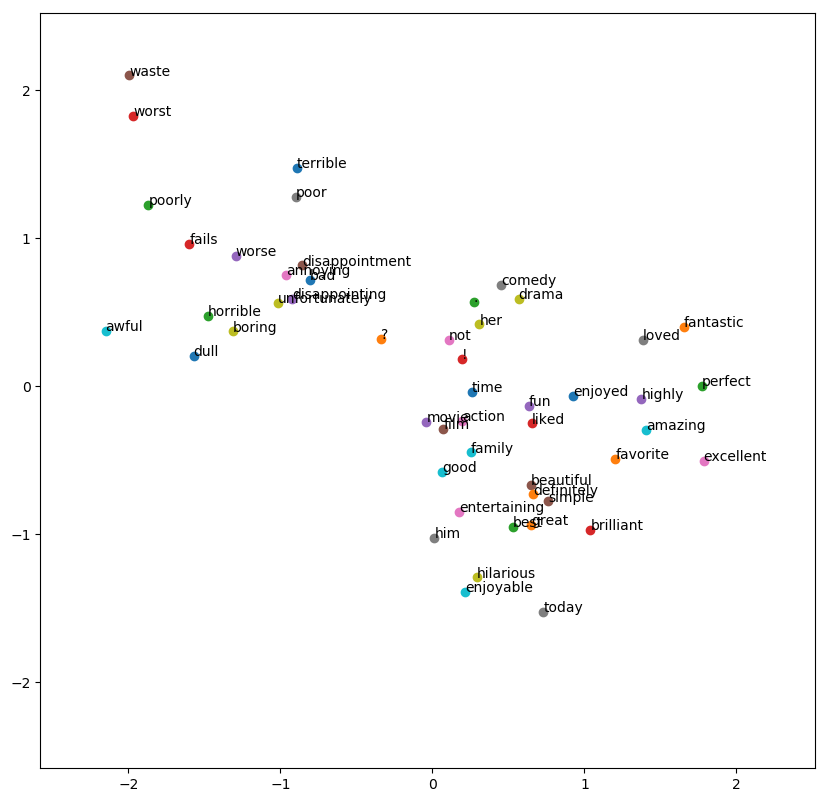

In [61]:
DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 10)
visualize_embedding(DNN_classifier, informative_terms)

Still, the projected data looks the same. This is because embedding does not use our final labels as its labels, actually the embedding process used trained model, which contains matrix to project our data into 2 dimensions. The projected data is based on the vocabulary itself, instead of our training labels.

## Improve the model's performance
What we can do
1. Tune the hyperparameters, choose a different optimizer
2. Adding additional terms to informative_terms

### AdamOptimizer and tune hyperparameters
There's a good article about [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). Basically, beta1 is the exponential decay rate for the first moment estimates, which keeps the mean of gradients decreasing. And beta2 is the exponential decay rate for the second moment estimates, which keeps the mean of squared gradients decreasing. Usually, it's recommended to set beta1 and beta2 close to 1 for most machine learning problems.

In [22]:
my_optimizer = tf.train.AdamOptimizer(learning_rate = 0.05, beta1=0.9, beta2=0.999, epsilon = 1e-8)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
# Here we use dimension of 2 to visualize.
# In practise, we might project to dimensions higher, like 50 or 100
DNN_classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.embedding_column(terms_feature_column, dimension = 2)],
    hidden_units = [20, 20], optimizer = my_optimizer)
try:
    DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([train_path]), steps = 1)
    print('Training set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([test_path]), steps = 1)
    print('Test set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
except ValueError as err:
    print(err)

Training set metrics:
accuracy --> 0.8
accuracy_baseline --> 0.52
auc --> 0.90064096
auc_precision_recall --> 0.9134728
average_loss --> 0.47307304
label/mean --> 0.52
loss --> 11.826826
prediction/mean --> 0.6510895
global_step --> 1000
---
Test set metrics:
accuracy --> 0.8
accuracy_baseline --> 0.52
auc --> 0.81410253
auc_precision_recall --> 0.75209844
average_loss --> 0.48510006
label/mean --> 0.52
loss --> 12.1275015
prediction/mean --> 0.5895881
global_step --> 1000
---


### Additional informative terms

In [25]:
# get the file
!curl -O https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   754k      0 --:--:-- --:--:-- --:--:--  757k


In [33]:
informative_terms = open('terms.txt', 'r').read().split()
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key = 'terms',
                                    vocabulary_list = informative_terms)

In [38]:
my_optimizer = tf.train.AdamOptimizer(learning_rate = 0.1, beta1=0.9, beta2=0.999, epsilon = 1e-8)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
# Here we use dimension of 2 to visualize.
# In practise, we might project to dimensions higher, like 50 or 100
DNN_classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.embedding_column(terms_feature_column, dimension = 2)],
    hidden_units = [20, 20], optimizer = my_optimizer)
try:
    DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    print('Training set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([test_path]), steps = 1000)
    print('Test set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
except ValueError as err:
    print(err)

Training set metrics:
accuracy --> 0.9378
accuracy_baseline --> 0.5
auc --> 0.9871865
auc_precision_recall --> 0.98693067
average_loss --> 0.16964145
label/mean --> 0.5
loss --> 4.241036
prediction/mean --> 0.44747156
global_step --> 1000
---
Test set metrics:
accuracy --> 0.85492
accuracy_baseline --> 0.5
auc --> 0.9452201
auc_precision_recall --> 0.94345444
average_loss --> 0.38569438
label/mean --> 0.5
loss --> 9.64236
prediction/mean --> 0.41536263
global_step --> 1000
---


**Adding more terms increases the accuracy**

### Try larger dimensions

In [40]:
# Try larger dimensions
DNN_classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.embedding_column(terms_feature_column, dimension = 50)],
    hidden_units = [20, 20], optimizer = my_optimizer)
try:
    DNN_classifier.train(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([train_path]), steps = 1000)
    print('Training set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
    eval_metrics = DNN_classifier.evaluate(input_fn = lambda: _input_fn([test_path]), steps = 1000)
    print('Test set metrics:')
    for i in eval_metrics:
        print(i, '-->', eval_metrics[i])
    print('---')
except ValueError as err:
    print(err)

Training set metrics:
accuracy --> 0.9488
accuracy_baseline --> 0.5
auc --> 0.9867303
auc_precision_recall --> 0.9871706
average_loss --> 0.1540394
label/mean --> 0.5
loss --> 3.850985
prediction/mean --> 0.5189393
global_step --> 1000
---
Test set metrics:
accuracy --> 0.87252
accuracy_baseline --> 0.5
auc --> 0.93989366
auc_precision_recall --> 0.9388994
average_loss --> 0.37637708
label/mean --> 0.5
loss --> 9.409427
prediction/mean --> 0.5161782
global_step --> 1000
---


No huge difference observed